# 17. Depth tune U1474 holes
This was an experimental step to align all possible parts of core from U1474 with the splice using the magnetitc susceptibility. Then if we checked green bands from all core sections we could compare splices and see if the records are similar

## Setup
### Import modules

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
from matplotlib.ticker import AutoMinorLocator
from scipy import signal,interpolate,stats,linalg
from IPython.display import clear_output
import time
import numpy as np
import seaborn as sns
%matplotlib inline
import os

### Set paths

In [3]:
data_path='/Users/danielbabin/GitHub/Green_Bands/Data/'
table_path='/Users/danielbabin/GitHub/Green_Bands/Tables/'
checkpoints_path='/Users/danielbabin/GitHub/Green_Bands/Data/Checkpoints/'

### Import splice info

In [4]:
splice=pd.read_csv(data_path+'SpliceTables/spliceConstructionE361.csv').iloc[0:57]
splice['CoreLabel']=(splice['Site']+splice['Hole']+'_'+splice['Core'].map(str))

section_list=pd.read_csv(data_path+'SectionSummaries/sectionSummaryU1474.csv')
section_list['SectionLabel']=(section_list['Site']+section_list['Hole']+'_'+
                              section_list['Core'].map(str)+section_list['Type']+section_list['Sect'].map(str))
section_list.rename(columns={'Top depth CCSF-361-U1474-ABDEF-20160220 (m)':'Top Depth CCSF (m)',
                            'Bottom depth CCSF-361-U1474-ABDEF-20160220 (m)':'Bottom Depth CCSF (m)'},inplace=True)

In [5]:
sections=section_list[(section_list['Top Depth CCSF (m)']<205)&
                      (section_list['Sect']!='CC')]['SectionLabel'].reset_index(drop=True)

## Magnetic susceptibility

### Import magnetic susceptibilty

In [6]:
ms=pd.read_csv(data_path+'U1474/magnetic_susceptibility.csv',low_memory=False)
ms=ms.rename(columns={ms.columns[9]:'Depth CCSF (m)'})
ms['SectionLabel']=(ms['Site']+ms['Hole']+'_'+
                    ms['Core'].map(str)+ms['Type']+ms['Sect'].map(str))
ms['CoreLabel']=(ms['Site']+ms['Hole']+'_'+ms['Core'].map(str))
ms=ms[ms['Magnetic susceptibility (instr. units)']<100].copy()

### Splice magnetic susceptibilty

In [7]:
for i,core in enumerate(splice.CoreLabel):
    deeper=ms.loc[ms['CoreLabel']==core,'Depth CCSF (m)']>splice.loc[i,'Top depth CCSF (m)']
    shallower=ms.loc[ms['CoreLabel']==core,'Depth CCSF (m)']<splice.loc[i,'Bottom depth CCSF (m)']
    ms.loc[ms['CoreLabel']==core,'In Splice']=deeper&shallower

In [8]:
ms_splice=ms[ms['In Splice']==True]
ms_splice=ms_splice.sort_values(by='Depth CCSF (m)').set_index('Depth CCSF (m)').loc[:205]

<Axes: xlabel='Depth CCSF (m)'>

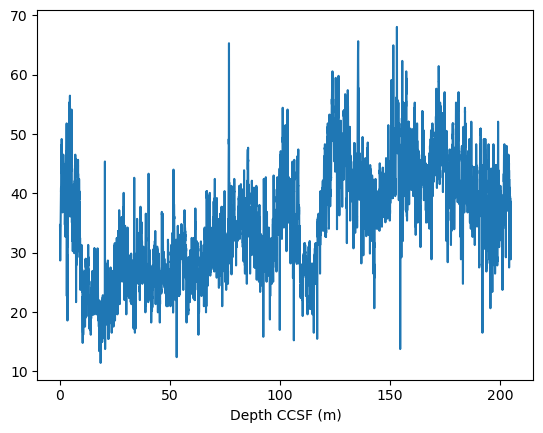

In [9]:
ms_splice['Magnetic susceptibility (instr. units)'].plot()

In [10]:
msA=ms[(ms['Hole']=='A')&
       (ms['Depth CCSF (m)']<205)].copy().sort_values(by='Depth CSF-A (m)').set_index('Depth CSF-A (m)',drop=False)
msB=ms[(ms['Hole']=='B')&
       (ms['Depth CCSF (m)']<205)].copy().sort_values(by='Depth CSF-A (m)').set_index('Depth CSF-A (m)',drop=False)
msC=ms[ms['Hole']=='C'].copy().sort_values(by='Depth CSF-A (m)').set_index('Depth CSF-A (m)',drop=False).loc[:80]
msD=ms[(ms['Hole']=='D')&
       (ms['Depth CCSF (m)']<205)].copy().sort_values(by='Depth CSF-A (m)').set_index('Depth CSF-A (m)',drop=False)
msF=ms[(ms['Hole']=='F')&
       (ms['Depth CCSF (m)']<205)].copy().sort_values(by='Depth CSF-A (m)').set_index('Depth CSF-A (m)',drop=False)

### Visualize different holes
Splice sections are black

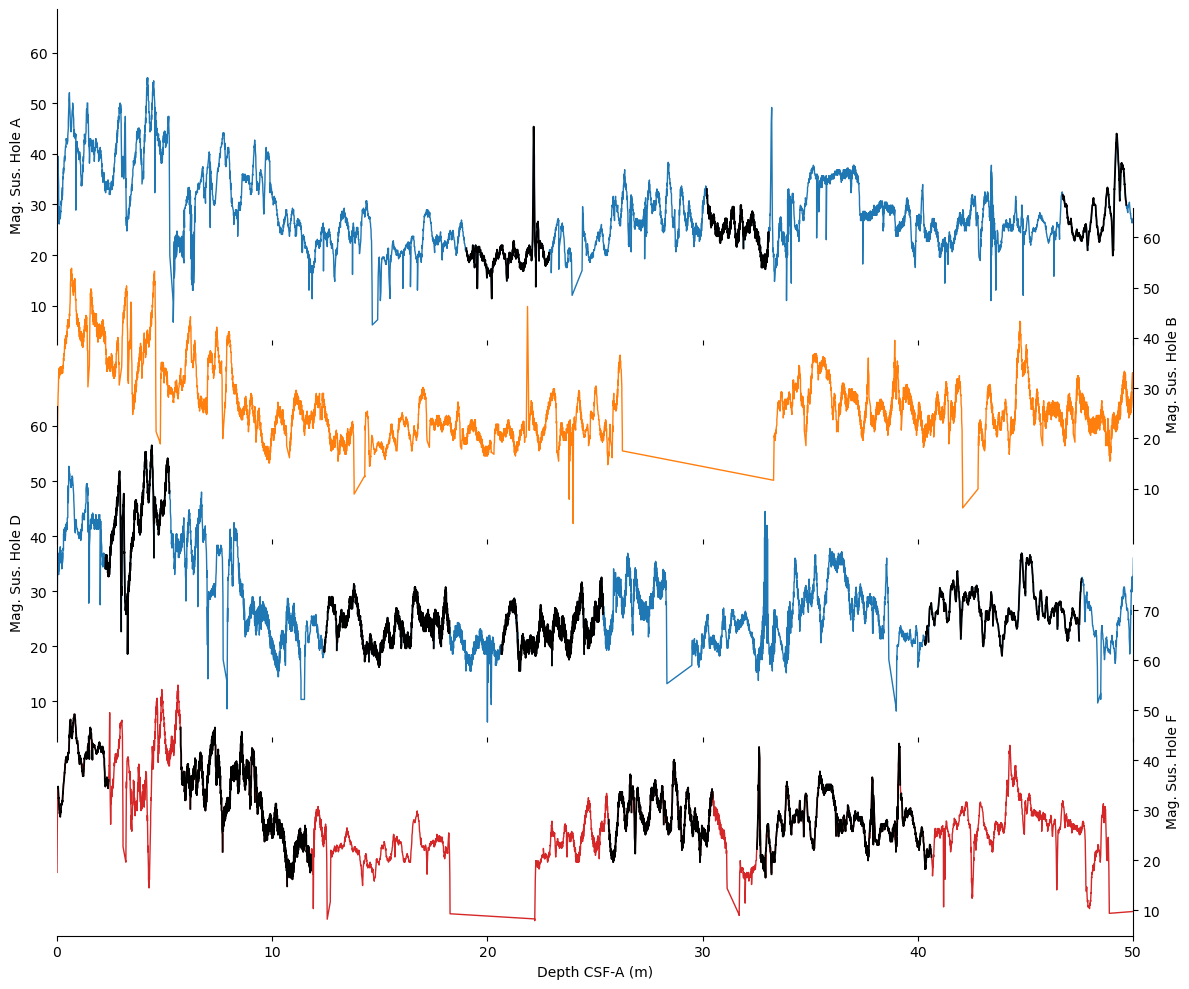

In [11]:
fig,axes=plt.subplots(nrows=4,figsize=(12,10),sharex=True)

sns.despine(ax=axes[0],bottom=True)
sns.despine(ax=axes[1],left=True,right=False,bottom=True)
sns.despine(ax=axes[2],bottom=True)
sns.despine(ax=axes[3],left=True,right=False)

for ax in axes:
    ax.patch.set_visible(False)
for ax in [axes[1],axes[3]]:
    ax.yaxis.set_label_position('right')

msA['Magnetic susceptibility (instr. units)'].plot(ax=axes[0],lw=1,color='tab:blue')
msB['Magnetic susceptibility (instr. units)'].plot(ax=axes[1],lw=1,color='tab:orange')
msD['Magnetic susceptibility (instr. units)'].plot(ax=axes[2],lw=1,color='tab:blue')
msF['Magnetic susceptibility (instr. units)'].plot(ax=axes[3],lw=1,color='tab:red')

for section in ms_splice['SectionLabel'].unique():
    df=ms_splice[ms_splice['SectionLabel']==section].copy()
    if df['Hole'].iloc[0]=='A':
        ax=axes[0]
    elif df['Hole'].iloc[0]=='B':
        ax=axes[1]
    elif df['Hole'].iloc[0]=='D':
        ax=axes[2]
    else:
        ax=axes[3]
    df.set_index('Depth CSF-A (m)')['Magnetic susceptibility (instr. units)'].plot(ax=ax,lw=1.3,color='k')
    
for i,hole in enumerate(['A','B','D','F']):
    axes[i].set_ylabel('Mag. Sus. Hole '+hole)


axes[-1].set_xlim(0,50)
plt.tight_layout()
plt.subplots_adjust(hspace=-.4)

In [12]:
names=['msSplice','msA','msB','msC','msD','msF']
var='Magnetic susceptibility (instr. units)'

### Export for QAnalyseries
This is external software that helps me align the records

In [13]:
for i,df in enumerate([ms_splice,msA,msB,msC,msD,msF]):
    df=df[df.index.duplicated()==False]
    df[var].to_csv(data_path+'QAnalyseries/Inputs/Magnetics/'+names[i]+'.csv',header=False)

## QAnalyseries Results

In [14]:
outputs_extension='QAnalyseries/Outputs/Magnetics/'

### Make functions to convert to splice depth

In [15]:
correlations={}
functions={}
for hole in ['A','B','C','D','F']:
    correlations[hole]=pd.read_csv(data_path+outputs_extension+'Hole'+hole+'.txt',engine='python',
                                   names=['Depth CSF-A (m)','Splice Depth CCSF (m)'],sep='\s')
    functions[hole]=interpolate.interp1d(correlations[hole]['Depth CSF-A (m)'],
                                         correlations[hole]['Splice Depth CCSF (m)'],
                                         bounds_error=False,fill_value='extrapolate')

### Apply function

In [16]:
msA['Splice Depth CCSF (m)']=functions['A'](msA.index)
msAcorr=msA.set_index('Splice Depth CCSF (m)',drop=False)

msB['Splice Depth CCSF (m)']=functions['B'](msB.index)
msBcorr=msB.set_index('Splice Depth CCSF (m)',drop=False)

msC['Splice Depth CCSF (m)']=functions['A'](msC.index)
msCcorr=msC.set_index('Splice Depth CCSF (m)',drop=False)

msD['Splice Depth CCSF (m)']=functions['D'](msD.index)
msDcorr=msD.set_index('Splice Depth CCSF (m)',drop=False)

msF['Splice Depth CCSF (m)']=functions['F'](msF.index)
msFcorr=msF.set_index('Splice Depth CCSF (m)',drop=False)

msCorrs={'A':msAcorr,'B':msBcorr,'C':msCcorr,'D':msDcorr,'F':msFcorr}

### Visualize depth tuned results

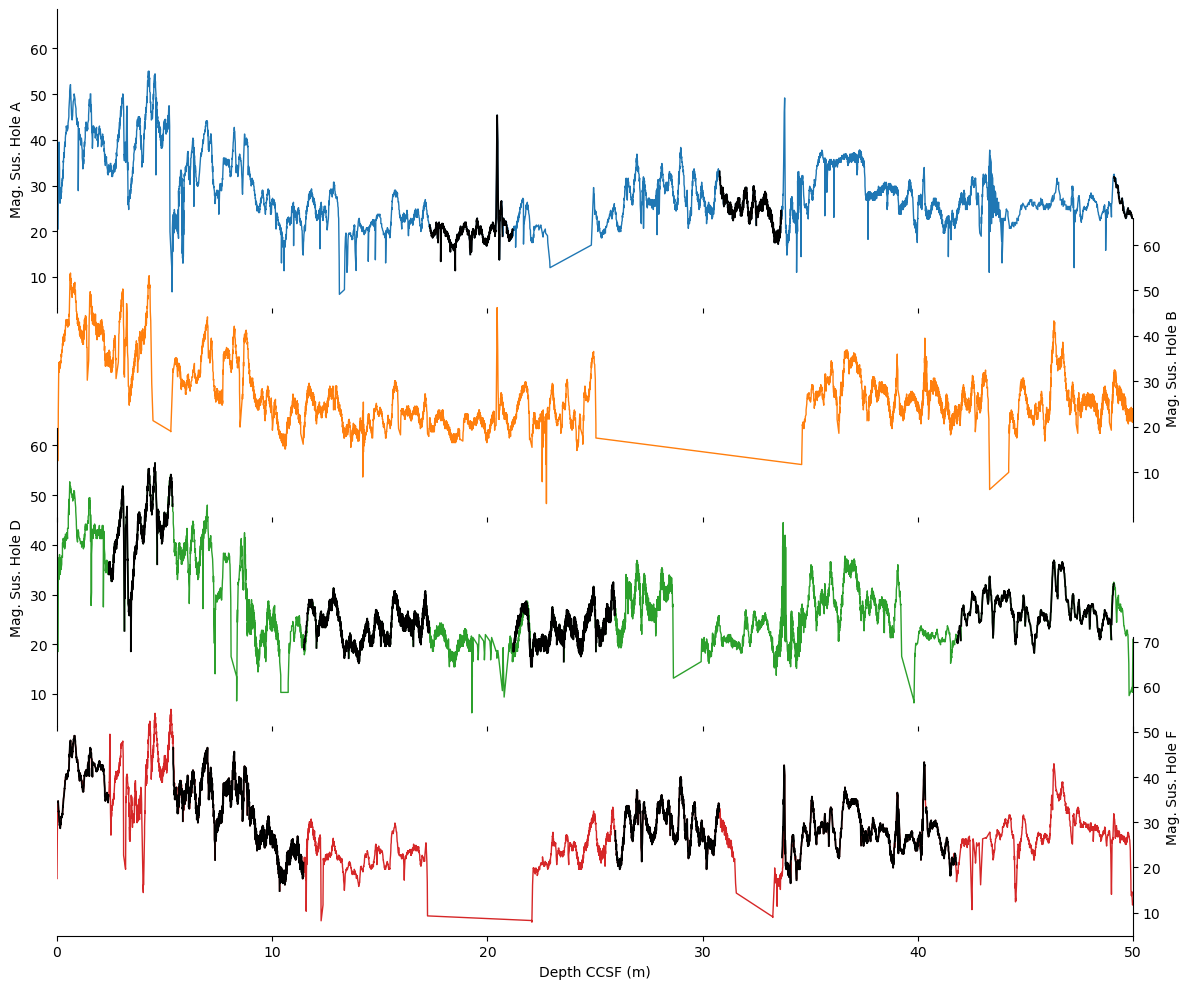

In [18]:
fig,axes=plt.subplots(nrows=4,figsize=(12,10),sharex=True)

sns.despine(ax=axes[0],bottom=True)
sns.despine(ax=axes[1],left=True,right=False,bottom=True)
sns.despine(ax=axes[2],bottom=True)
sns.despine(ax=axes[3],left=True,right=False)

for ax in axes:
    ax.patch.set_visible(False)
for ax in [axes[1],axes[3]]:
    ax.yaxis.set_label_position('right')

msAcorr['Magnetic susceptibility (instr. units)'].plot(ax=axes[0],lw=1,color='tab:blue')
msBcorr['Magnetic susceptibility (instr. units)'].plot(ax=axes[1],lw=1,color='tab:orange')
msDcorr['Magnetic susceptibility (instr. units)'].plot(ax=axes[2],lw=1,color='tab:green')
msFcorr['Magnetic susceptibility (instr. units)'].plot(ax=axes[3],lw=1,color='tab:red')

for section in ms_splice['SectionLabel'].unique():
    df=ms_splice[ms_splice['SectionLabel']==section].copy()
    if df['Hole'].iloc[0]=='A':
        ax=axes[0]
    elif df['Hole'].iloc[0]=='B':
        ax=axes[1]
    elif df['Hole'].iloc[0]=='D':
        ax=axes[2]
    else:
        ax=axes[3]
    df['Magnetic susceptibility (instr. units)'].plot(ax=ax,lw=1.3,color='k')
    
for i,hole in enumerate(['A','B','D','F']):
    axes[i].set_ylabel('Mag. Sus. Hole '+hole)


axes[-1].set_xlim(0,50)
plt.tight_layout()
plt.subplots_adjust(hspace=-.3)

### Clear Disturbed Sections
These values were manually entered based on core imagery

In [19]:
disturbedA=[['U1474A_2H1',0,112],['U1474A_3H1',0,150],['U1474A_3H2',0,4],['U1474A_4H1',0,50],
            ['U1474A_5H1',0,150],['U1474A_5H2',0,150],['U1474A_5H3',0,150],['U1474A_5H4',0,150],
            ['U1474A_5H5',0,23],['U1474A_6H1',0,113],['U1474A_7H1',0,135],['U1474A_8H1',0,150],
            ['U1474A_8H2',0,8],['U1474A_9H1',0,58],['U1474A_10H1',0,150],['U1474A_11H1',0,7],
            ['U1474A_12H1',0,63],['U1474A_13H1',0,86],['U1474A_14H1',0,75],['U1474A_15H1',0,8],
            ['U1474A_16H1',0,31],['U1474A_17H1',0,28],['U1474A_18H7',39,75],['U1474A_18H1',0,60],
            ['U1474A_19H1',0,71],['U1474A_20H1',0,21],['U1474A_21H1',0,64]]

disturbedB=[['U1474B_1H1',0,8],['U1474B_2H1',0,113],['U1474B_3H1',0,151],['U1474B_5H1',0,38],['U1474B_6H1',0,35],
            ['U1474B_7H1',0,70],['U1474B_8H1',0,52],['U1474B_9H1',0,10],['U1474B_10H1',0,75],['U1474B_11H1',0,11],
            ['U1474B_12H1',0,11],['U1474B_13H1',0,128],['U1474B_14H1',0,115],['U1474B_15H1',0,93],
            ['U1474B_16H1',0,5],['U1474B_16H1',0,5],['U1474B_16H4',34,105]]

disturbedC=[['U1474C_1H1',0,10]]

disturbedD=[['U1474D_2H1',0,20],['U1474D_3H1',0,65],['U1474D_4H1',0,37],['U1474D_5H1',0,150],['U1474D_6H1',0,65],
            ['U1474D_7H1',0,70],['U1474D_8H1',0,102],['U1474D_9H1',0,10],['U1474D_10H1',0,12],['U1474D_11H1',0,16],
            ['U1474D_12H1',0,71],['U1474D_13H1',0,7],['U1474D_14H1',0,73]]

disturbedF=[['U1474F_2H1',0,120],['U1474F_3H1',0,121],['U1474F_4H1',0,25],['U1474F_5H1',0,67],['U1474F_6H1',0,33],
            ['U1474F_6H2',55,110],['U1474F_7H1',0,52],['U1474F_8H1',0,5],['U1474F_9H1',0,5]]

In [20]:
disturbeds=[disturbedA,disturbedB,disturbedC,disturbedD,disturbedF]

#### Make table

In [21]:
disturbed_intervals=pd.concat([pd.DataFrame(df,columns=['SectionLabel','Top offset (cm)',
                                                        'Bottom offset (cm)']) for df in disturbeds])

In [22]:
disturbed_intervals['Exp']=disturbed_intervals['SectionLabel'].str[:5]
disturbed_intervals['Hole']=disturbed_intervals['SectionLabel'].str[5]
disturbed_intervals['Core']=disturbed_intervals['SectionLabel'].str[7]
disturbed_intervals['Section']=disturbed_intervals['SectionLabel'].str[-1]
col_names=['Exp','Hole','Core','Section','Top offset (cm)','Bottom offset (cm)','SectionLabel']
disturbed_intervals=disturbed_intervals[col_names].reset_index(drop=True)

#### Export

In [23]:
disturbed_intervals.to_csv(table_path+'Supplementary Table X Site U1474 Disturbed Invervals.csv',index=False)

### Clean record

In [24]:
msCorrCleans={}
for hole in ['A','B','C','D','F']:
    msCorrCleans[hole]=msCorrs[hole].copy()
    hole_intervals=disturbed_intervals[disturbed_intervals['Hole']==hole]
    
        

    ### disturbed intervals
    for i in hole_intervals.index: 
        sect=disturbed_intervals.loc[i,'SectionLabel']
        top_offset=disturbed_intervals.loc[i,'Top offset (cm)']
        bot_offset=disturbed_intervals.loc[i,'Bottom offset (cm)']
        logic=((msCorrCleans[hole]['SectionLabel']==sect)&
               (msCorrCleans[hole]['Offset (cm)'].between(top_offset,bot_offset)))
        msCorrCleans[hole].loc[logic,'Magnetic susceptibility (instr. units)']=np.nan
        
    msCorrCleans[hole]=msCorrCleans[hole].dropna(subset=['Magnetic susceptibility (instr. units)'])     
        
    ### core bottoms
    for core in msCorrCleans[hole].Core.unique():
        ids=msCorrCleans[hole][msCorrCleans[hole]['Core']==core].index[-5:]
        msCorrCleans[hole].loc[ids,'Magnetic susceptibility (instr. units)']=np.nan

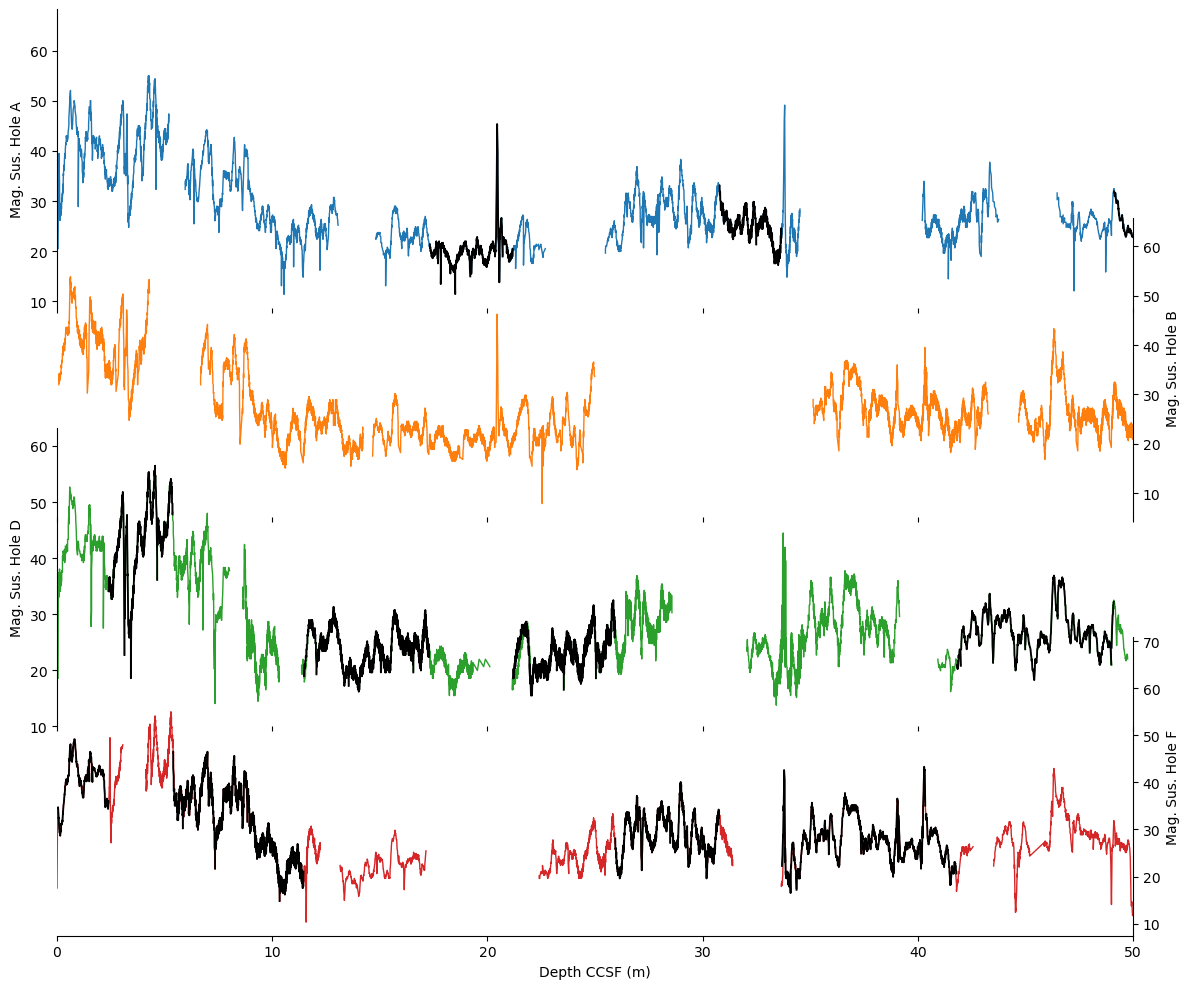

In [25]:
fig,axes=plt.subplots(nrows=4,figsize=(12,10),sharex=True)

sns.despine(ax=axes[0],bottom=True)
sns.despine(ax=axes[1],left=True,right=False,bottom=True)
sns.despine(ax=axes[2],bottom=True)
sns.despine(ax=axes[3],left=True,right=False)

for ax in axes:
    ax.patch.set_visible(False)
for ax in [axes[1],axes[3]]:
    ax.yaxis.set_label_position('right')

msCorrCleans['A']['Magnetic susceptibility (instr. units)'].plot(ax=axes[0],lw=1,color='tab:blue')
msCorrCleans['B']['Magnetic susceptibility (instr. units)'].plot(ax=axes[1],lw=1,color='tab:orange')
msCorrCleans['D']['Magnetic susceptibility (instr. units)'].plot(ax=axes[2],lw=1,color='tab:green')
msCorrCleans['F']['Magnetic susceptibility (instr. units)'].plot(ax=axes[3],lw=1,color='tab:red')

for section in ms_splice['SectionLabel'].unique():
    df=ms_splice[ms_splice['SectionLabel']==section].copy()
    if df['Hole'].iloc[0]=='A':
        ax=axes[0]
    elif df['Hole'].iloc[0]=='B':
        ax=axes[1]
    elif df['Hole'].iloc[0]=='D':
        ax=axes[2]
    else:
        ax=axes[3]
    df['Magnetic susceptibility (instr. units)'].plot(ax=ax,lw=1.3,color='k')
    
for i,hole in enumerate(['A','B','D','F']):
    axes[i].set_ylabel('Mag. Sus. Hole '+hole)


axes[-1].set_xlim(0,50)
plt.tight_layout()
plt.subplots_adjust(hspace=-.3)

### Check Super-Splice Core m per m
It seems like there is basically only material for 2 splices

In [26]:
isCore={}
for hole in ['A','B','D','F']:
    isCore[hole]=msCorrs[hole][msCorrs[hole].index.duplicated()==False].loc[0:80].reindex(np.linspace(0,80,80001),
                                                                                          method='nearest')
    isCore[hole]['Usable']=True
    hole_intervals=disturbed_intervals[disturbed_intervals['Hole']==hole]
    
    ### disturbed intervals
    for i in hole_intervals.index: 
        sect=disturbed_intervals.loc[i,'SectionLabel']
        top_offset=disturbed_intervals.loc[i,'Top offset (cm)']
        bot_offset=disturbed_intervals.loc[i,'Bottom offset (cm)']
        logic=((isCore[hole]['SectionLabel']==sect)&
               (isCore[hole]['Offset (cm)'].between(top_offset,bot_offset)))
        isCore[hole].loc[logic,'Usable']=False
    isCore[hole]['Usable']=isCore[hole]['Usable'].astype(int)

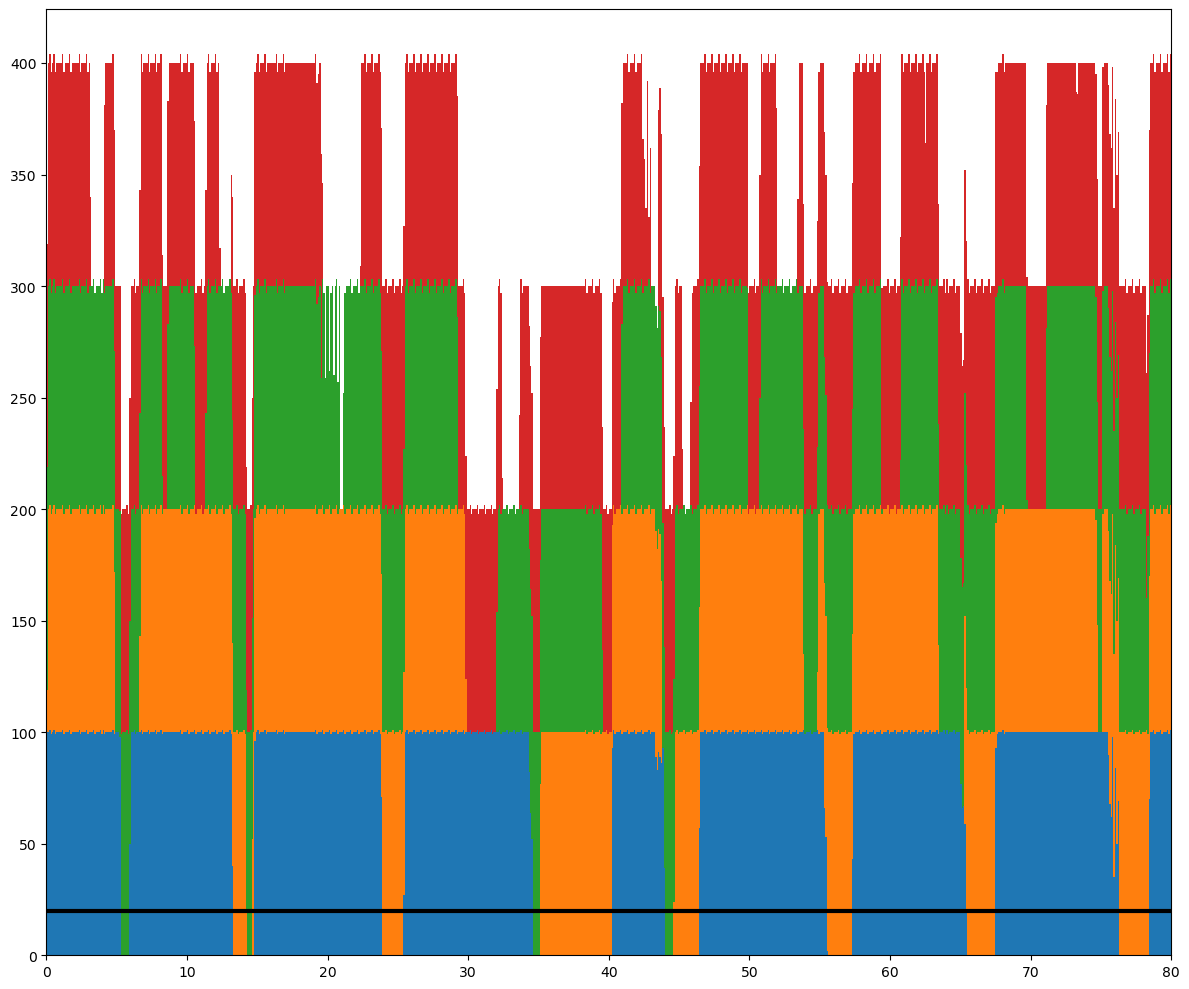

In [27]:
fig,ax=plt.subplots(figsize=(12,10))
ax.hist([isCore['A'][isCore['A']['Usable']==True].index,isCore['B'][isCore['B']['Usable']==True].index,
         isCore['D'][isCore['D']['Usable']==True].index,isCore['F'][isCore['F']['Usable']==True].index],
        stacked=True,bins=np.linspace(0,80,801))
ax.set_xlim(0,80)
ax.axhline(20,color='k',lw=3)
plt.tight_layout()

### Create Splice B

In [28]:
spliceB=pd.DataFrame({'Top Interval CCSF':[0,4.47,5.39,6.81,12.08,14.03,16.00,17.29,19.32,23.33,25.95,28.27,
                                           32.6,36,40.74,43.55,44.94,52.54,54.13,57.14,62.41,65.14,67.80,
                                           72.24,77.23],
                      'Bottom Interval CCSF':[4.47,5.39,6.81,12.08,14.03,16.00,17.29,19.32,23.33,25.95,28.27,32.6,
                                              36,40.74,43.55,44.94,52.54,54.13,57.14,62.41,65.14,67.80,72.24,
                                              77.23,80],
                      'Hole':['A','F','D','A','B','F','A','D','B','F','D','A',
                              'D','B','A','F','B','A','F','B','A','F','B','D','B']})

In [29]:
%matplotlib inline

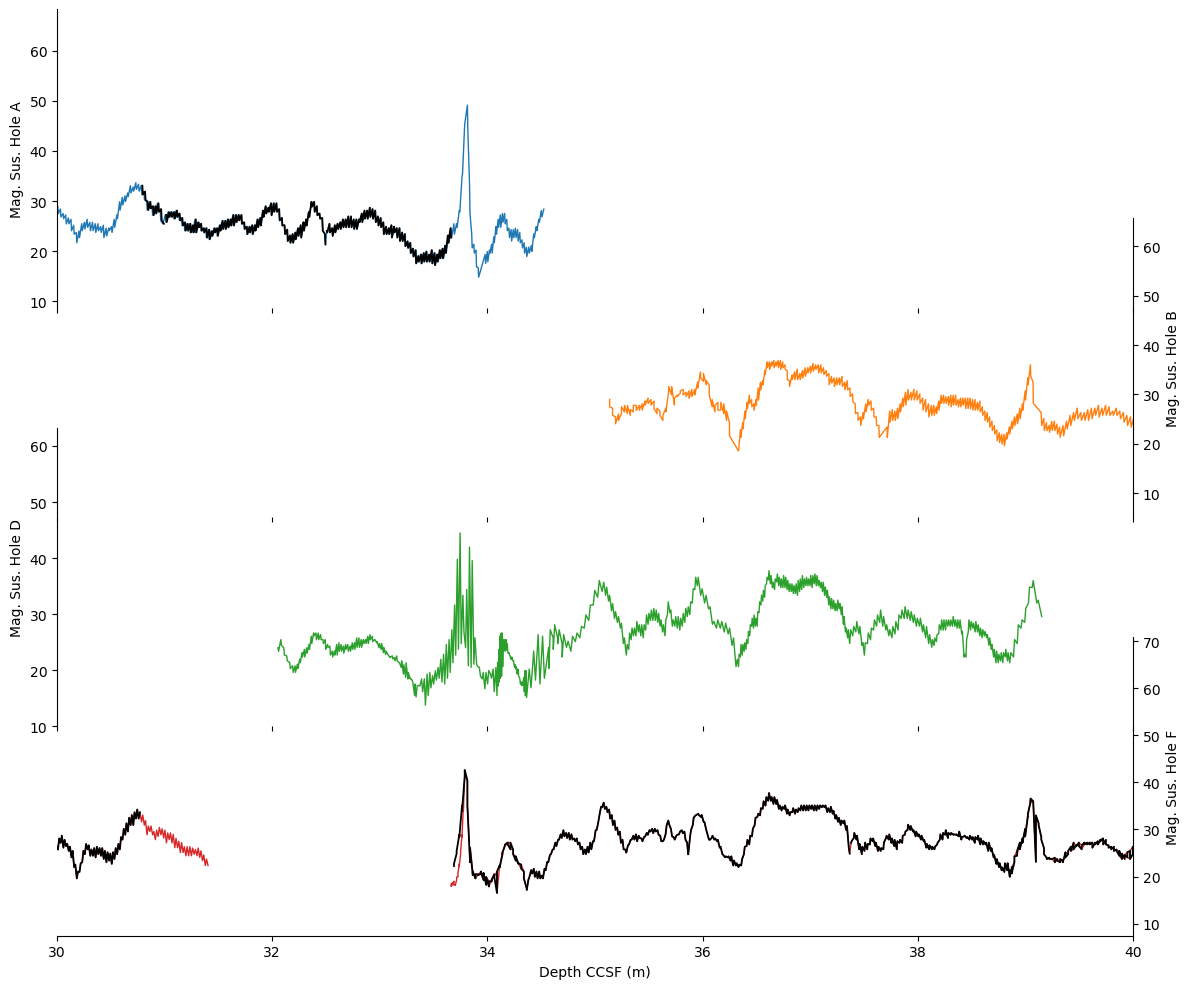

In [30]:
fig,axes=plt.subplots(nrows=4,figsize=(12,10),sharex=True)

sns.despine(ax=axes[0],bottom=True)
sns.despine(ax=axes[1],left=True,right=False,bottom=True)
sns.despine(ax=axes[2],bottom=True)
sns.despine(ax=axes[3],left=True,right=False)

for ax in axes:
    ax.patch.set_visible(False)
for ax in [axes[1],axes[3]]:
    ax.yaxis.set_label_position('right')

msCorrCleans['A']['Magnetic susceptibility (instr. units)'].plot(ax=axes[0],lw=1,color='tab:blue')
msCorrCleans['B']['Magnetic susceptibility (instr. units)'].plot(ax=axes[1],lw=1,color='tab:orange')
msCorrCleans['D']['Magnetic susceptibility (instr. units)'].plot(ax=axes[2],lw=1,color='tab:green')
msCorrCleans['F']['Magnetic susceptibility (instr. units)'].plot(ax=axes[3],lw=1,color='tab:red')

for section in ms_splice['SectionLabel'].unique():
    df=ms_splice[ms_splice['SectionLabel']==section].copy()
    if df['Hole'].iloc[0]=='A':
        ax=axes[0]
    elif df['Hole'].iloc[0]=='B':
        ax=axes[1]
    elif df['Hole'].iloc[0]=='D':
        ax=axes[2]
    else:
        ax=axes[3]
    df['Magnetic susceptibility (instr. units)'].plot(ax=ax,lw=1.3,color='k')
    
for i,hole in enumerate(['A','B','D','F']):
    axes[i].set_ylabel('Mag. Sus. Hole '+hole)

axes[-1].set_xlim(30,40)
plt.tight_layout()
plt.subplots_adjust(hspace=-.3)

### Connect Green Layers 

In [31]:
green_layers=pd.read_csv(checkpoints_path+'green.peak.labeling.U1474.csv')

In [32]:
# max_id=green_layers.index.max()+1
# h2=[0.957,361,'U1474','D',1,'H',1,80.5,83.5,0.9870,3.0,3,max_id,max_id,'U1474D_1H1']
# green_layers.loc[max_id]=h2

In [33]:
for i,sect in enumerate(green_layers['SectionLabel']):
    csfA_sect_top=section_list.set_index('SectionLabel').loc[sect,'Top depth CSF-A (m)']
    layer_top_offset=green_layers.loc[i,'Top Offset (cm)']
    layer_bot_offset=green_layers.loc[i,'Bottom Offset (cm)']
    layer_csfA_top=csfA_sect_top+layer_top_offset/100
    layer_csfA_bot=csfA_sect_top+layer_bot_offset/100
    green_layers.loc[i,'Top Depth CSF-A (m)']=layer_csfA_top
    green_layers.loc[i,'Bottom Depth CSF-A (m)']=layer_csfA_bot

In [34]:
holes_green_layers={}
for hole in ['A','B','D','F']: 
    holes_green_layers[hole]=green_layers[green_layers['Hole']==hole].copy()
    holes_green_layers[hole]['Top Splice Depth CCSF (m)']=functions[hole](holes_green_layers[hole]
                                                                          ['Top Depth CSF-A (m)'])
    holes_green_layers[hole]['Bottom Splice Depth CCSF (m)']=functions[hole](holes_green_layers[hole]
                                                                             ['Bottom Depth CSF-A (m)'])

In [35]:
holes_green_true={}
for hole in ['A','B','D','F']: 
    holes_green_true[hole]=holes_green_layers[hole][holes_green_layers[hole]['Label']>1].copy()
    holes_green_true[hole]=holes_green_true[hole].sort_values('Top Depth CCSF (m)').reset_index(drop=True)

### Splice A Green Layers

In [36]:
for hole in ['A','B','D','F']:
    holes_green_true[hole]['CoreLabel']=(holes_green_true[hole]['Site']+holes_green_true[hole]['Hole']+'_'
                                         +holes_green_true[hole]['Core'].map(str))
    holes_green_true[hole]['In Splice']=False
    for i,core in enumerate(splice.CoreLabel):
        intv_top=splice.loc[i,'Top depth CCSF (m)']
        intv_bottom=splice.loc[i,'Bottom depth CCSF (m)']
        top_kind='Top Depth CCSF (m)'
        bottom_kind='Bottom Depth CCSF (m)'
        deeper=holes_green_true[hole].loc[holes_green_true[hole]['CoreLabel']==core,top_kind]>intv_top
        shallower=holes_green_true[hole].loc[holes_green_true[hole]['CoreLabel']==core,bottom_kind]<intv_bottom
        both=deeper&shallower
        ids=both[both==True].index
        holes_green_true[hole].loc[ids,'In Splice']=True

In [37]:
spliceA_gls=pd.concat([holes_green_true[hole][holes_green_true[hole]['In Splice']==True]
                               for hole in ['A','B','D','F']])
spliceA_gls=spliceA_gls.set_index('Top Splice Depth CCSF (m)',drop=False).sort_index()

In [38]:
am=pd.read_csv(table_path+'Supplementary Table 2 - Age-depth model.csv')
fam=interpolate.interp1d(am['Depth CCSF (m)'],am['Age (kyr)'],bounds_error=False,fill_value='extrapolate')

In [39]:
spliceA_gls['Age (kyr)']=fam(spliceA_gls.index)
aspliceA_gls=spliceA_gls.set_index('Age (kyr)')

### Splice B Green Layers

In [40]:
green_layers_all=pd.concat([holes_green_true[hole] for hole in ['A','B','D','F']]).reset_index()

In [41]:
spliceB_gls=pd.DataFrame(columns=green_layers_all.columns)
for i in spliceB.index:
    top=spliceB.loc[i,'Top Interval CCSF']
    bot=spliceB.loc[i,'Bottom Interval CCSF']
    hole=spliceB.loc[i,'Hole']
    betw_logic=green_layers_all['Top Splice Depth CCSF (m)'].between(top,bot)
    hole_logic=green_layers_all['Hole']==hole
    ids=green_layers_all.loc[betw_logic&hole_logic].index
    trues=green_layers_all.loc[ids]
    spliceB_gls=pd.concat([spliceB_gls,trues])

/var/folders/5g/c_zltr_s4ws8lr9yxmzvqv3r0000gn/T/ipykernel_37615/4098696805.py:10: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  spliceB_gls=pd.concat([spliceB_gls,trues])
/var/folders/5g/c_zltr_s4ws8lr9yxmzvqv3r0000gn/T/ipykernel_37615/4098696805.py:10: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  spliceB_gls=pd.concat([spliceB_gls,trues])
/var/folders/5g/c_zltr_s4ws8lr9yxmzvqv3r0000gn/T/ipykernel_37615/4098696805.py:10: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  spliceB_gls=pd.concat([spliceB_gls,trues])
/var/folders/5g/c_zltr_s4ws8lr9yxmzvqv3r0000gn/T/ipykernel_37615/4098696805.py:10: FutureWarning:

In [42]:
spliceB_gls=spliceB_gls.set_index('Top Splice Depth CCSF (m)',drop=False).sort_index()
spliceB_gls['Age (kyr)']=fam(spliceB_gls.index)
aspliceB_gls=spliceB_gls.set_index('Age (kyr)')

### Both

In [43]:
spliceBoth_gls=pd.concat([spliceA_gls,spliceB_gls])
spliceBoth_gls=spliceBoth_gls.sort_index()

/var/folders/5g/c_zltr_s4ws8lr9yxmzvqv3r0000gn/T/ipykernel_37615/4159779241.py:1: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  spliceBoth_gls=pd.concat([spliceA_gls,spliceB_gls])


## Visualize

In [44]:
greens=sns.color_palette('Greens_r',4)

In [45]:
tab20=sns.color_palette('tab20')

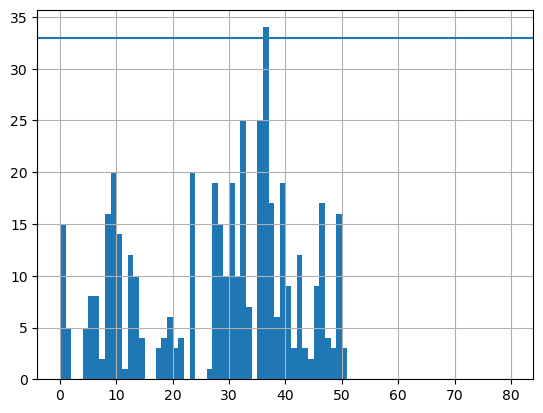

In [46]:
ax=spliceBoth_gls['Top Splice Depth CCSF (m)'].hist(bins=np.linspace(0,80,81))
ax.axhline(33)

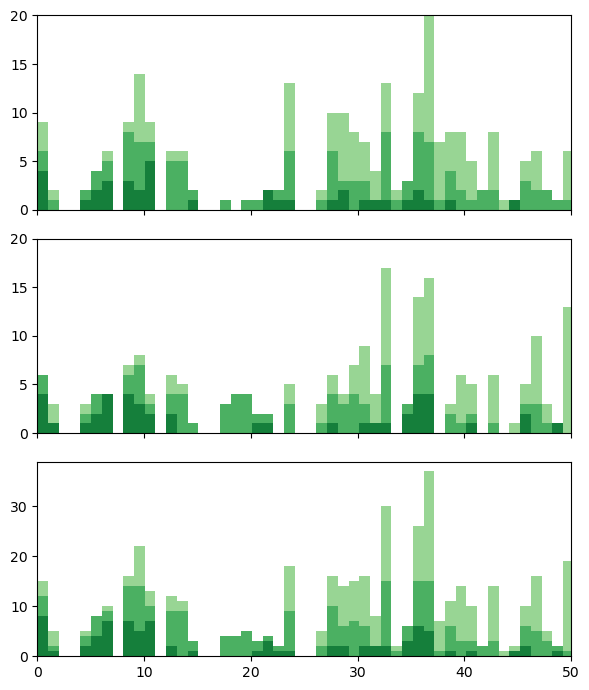

In [47]:
fig,axes=plt.subplots(nrows=3,sharex=True,figsize=(6,7))
axes[0].hist([spliceA_gls.loc[spliceA_gls['Label']==4,'Top Splice Depth CCSF (m)'],
              spliceA_gls.loc[spliceA_gls['Label']==3,'Top Splice Depth CCSF (m)'],
              spliceA_gls.loc[spliceA_gls['Label']==2,'Top Splice Depth CCSF (m)']],
              bins=np.linspace(0,205,205),color=greens[:-1],stacked=True)

axes[1].hist([spliceB_gls.loc[spliceB_gls['Label']==4,'Top Splice Depth CCSF (m)'],
              spliceB_gls.loc[spliceB_gls['Label']==3,'Top Splice Depth CCSF (m)'],
              spliceB_gls.loc[spliceB_gls['Label']==2,'Top Splice Depth CCSF (m)']],
              bins=np.linspace(0,205,205),color=greens[:-1],stacked=True)

axes[2].hist([spliceBoth_gls.loc[spliceBoth_gls['Label']==4,'Top Splice Depth CCSF (m)'],
              spliceBoth_gls.loc[spliceBoth_gls['Label']==3,'Top Splice Depth CCSF (m)'],
              spliceBoth_gls.loc[spliceBoth_gls['Label']==2,'Top Splice Depth CCSF (m)']],
              bins=np.linspace(0,205,205),color=greens[:-1],stacked=True)
# spliceBoth_gls['Top Splice Depth CCSF (m)'].plot(kind='kde',ax=axes[2],secondary_y=True)

axes[-1].set_xlim(0,50)
for ax in axes[:-1]:
    ax.set_ylim(0,20)
plt.subplots_adjust(hspace=.06)
plt.tight_layout()

### Age model

In [48]:
amU1474=pd.read_csv(table_path+'Supplementary Table 2 - Age-depth model.csv')
amU1474['Top Interval Depth CCSF (m)']=amU1474['Depth CCSF (m)'].shift(1)
amU1474['Top Interval Age (kyr)']=amU1474['Age (kyr)'].shift(1)
famU1474=interpolate.interp1d(amU1474['Depth CCSF (m)'],amU1474['Age (kyr)'],bounds_error=False)

In [49]:
spliceA_gls['Top Age (kyr)']=famU1474(spliceA_gls['Top Splice Depth CCSF (m)'])
spliceA_gls['Bottom Age (kyr)']=famU1474(spliceA_gls['Bottom Splice Depth CCSF (m)'])
agtU1474_spliceA=spliceA_gls[~spliceA_gls['Top Age (kyr)'].isnull()].set_index('Top Age (kyr)').sort_index()

In [50]:
spliceB_gls['Top Age (kyr)']=famU1474(spliceB_gls['Top Splice Depth CCSF (m)'])
spliceB_gls['Bottom Age (kyr)']=famU1474(spliceB_gls['Bottom Splice Depth CCSF (m)'])
agtU1474_spliceB=spliceB_gls[~spliceB_gls['Top Age (kyr)'].isnull()].set_index('Top Age (kyr)').sort_index()

In [51]:
step=1
bin_edges=np.arange(0,5235+step,step,dtype=int)

In [52]:
col_list=['U1474_A','U1474_C2+_A', 'U1474_C3_A',
          'U1474_B','U1474_C2+_B', 'U1474_C3_B']

In [53]:
records=pd.DataFrame(0,index=bin_edges,columns=col_list)
for i,site in enumerate([agtU1474_spliceA,agtU1474_spliceB]):
# for i,site in enumerate([agtU1474,agt1313,agt659,agt1143,agt758,agtU1489]):
    if i == 0:
        splice='A'
    else:
        splice='B'
        
    sitename=site['Site'].iloc[0]+'_'+splice
    nearest=np.round(site.index/step)*step
    site['Nearest']=nearest
    
    thicknesses_total=site.groupby('Nearest').sum(numeric_only=True)['Thickness (cm)']
    # thicknesses_c2_plus=site[site['Class']>1].groupby('Nearest').sum(numeric_only=True)['Thickness (cm)']
    # thicknesses_c3=site[site['Class']==3].groupby('Nearest').sum(numeric_only=True)['Thickness (cm)']
    records.loc[thicknesses_total.index,str(sitename)]=thicknesses_total.values
    # records.loc[thicknesses_c2_plus.index,str(sitename)+'_C2+']=thicknesses_c2_plus.values
    # records.loc[thicknesses_c3.index,str(sitename)+'_C3']=thicknesses_c3.values

<Axes: >

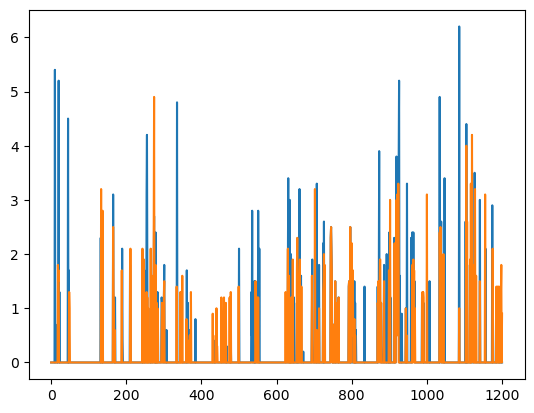

In [54]:
records['U1474_A'].loc[0:1200].plot()
records['U1474_B'].loc[0:1200].plot()

<Axes: >

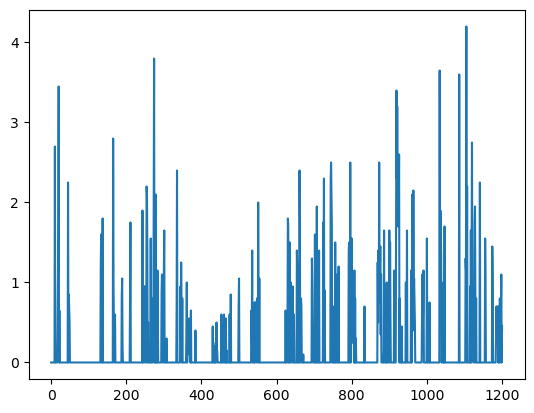

In [55]:
records['U1474']=((records['U1474_A']+records['U1474_B'])/2)
records['U1474'].loc[0:1200].plot()

## Export

In [56]:
dgreen_layers_all=green_layers_all.set_index('Top Splice Depth CCSF (m)')
dgreen_layers_all['Splice']=None
dgreen_layers_all['In Splice A']=False
dgreen_layers_all['In Splice B']=False
dgreen_layers_all.loc[spliceA_gls.index,'In Splice A']=True
dgreen_layers_all.loc[spliceB_gls.index,'In Splice B']=True
dgreen_layers_all.loc[spliceA_gls.index,'Splice']='A'
dgreen_layers_all.loc[spliceB_gls.index,'Splice']='B'
dgreen_layers_all.loc[(dgreen_layers_all['In Splice A']==True)&
                      (dgreen_layers_all['In Splice B']==True),'Splice']='Both'

In [57]:
green_layers_all[['In Splice','Splice']]=dgreen_layers_all[['In Splice','Splice']].values

In [58]:
keep_cols=['Exp', 'Site', 'Hole', 'Core', 'Type', 'Section',
           'Top Offset (cm)', 'Bottom Offset (cm)', 'Top Depth CSF-A (m)', 'Bottom Depth CSF-A (m)', 
           'Top Depth CCSF (m)', 'Bottom Depth CCSF (m)', 'Top Splice Depth CCSF (m)', 
           'Bottom Splice Depth CCSF (m)', 'Thickness (cm)', 'N', 'Label', 'In Splice', 'Splice']

In [59]:
green_layers_all=green_layers_all[keep_cols]
green_layers_all=green_layers_all.rename(columns={'Label':'Class'})
green_layers_all['Class']=green_layers_all['Class']-1

In [60]:
# green_layers_all.to_csv(table_path+'Table X All Green Layers.csv',index=False)

### Splice Layers

In [61]:
keep_cols=['Exp', 'Site', 'Hole', 'Core', 'Type', 'Section',
           'Top Offset (cm)', 'Bottom Offset (cm)', 'Top Depth CSF-A (m)', 'Bottom Depth CSF-A (m)', 
           'Top Depth CCSF (m)', 'Bottom Depth CCSF (m)', 'Top Splice Depth CCSF (m)', 
           'Bottom Splice Depth CCSF (m)', 'Thickness (cm)', 'N', 'Label']

In [62]:
splice_green_layers=spliceBoth_gls[keep_cols].copy()
splice_green_layers=splice_green_layers.rename(columns={'Label':'Class'})
splice_green_layers['Class']=splice_green_layers['Class']-1

In [63]:
bothids=splice_green_layers[splice_green_layers.duplicated()].index

In [64]:
splice_green_layers['Splice']=None
splice_green_layers.loc[spliceA_gls.index,'Splice']='A'
splice_green_layers.loc[spliceB_gls.index,'Splice']='B'
splice_green_layers.loc[bothids,'Splice']='Both'
splice_green_layers=splice_green_layers.drop_duplicates().copy()

In [69]:
extra_cols=['Top Splice Depth CCSF (m)', 'Bottom Splice Depth CCSF (m)','Splice']
spliceA_green_layers_final=splice_green_layers[(splice_green_layers['Splice']=='A')|(splice_green_layers['Splice']=='Both')].copy().drop(extra_cols,axis=1)

In [71]:
spliceA_green_layers_final.to_csv(table_path+'Supplementary Table 6A - U1474 green bands.csv',
                                  index=False)